In [43]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    %matplotlib widget
    figsize=(9, 3)
else:
    figsize=(14, 4)

from util import util
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.neighbors import KernelDensity

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Problem and Data


## Anomaly Detection on Taxi Calls

**We are contacted by a Taxi company:**

<center><img src="assets/sized-yellow-taxi.jpg" width="70%"/></center>

## Anomaly Detection on Taxi Calls

**We are contacted by a Taxi company:**

* They have historical data about taxi calls in NYC
* They are interested in detecting "abnormal situations" (so called _anomalies_)

**Goals:**

* Analyze anomalies (e.g. better size the fleet)
* Anticipate anomalies (so we can prepare)

**Typically referred to as _anomaly detection_:**

* An important industrial problem
* Many context and possible applications

## Loading the Data

In [44]:
data_folder = os.path.join('data', 'nab')
file_name = os.path.join('realKnownCause', 'nyc_taxi.csv')
data, labels, windows = util.load_taxi_series(file_name, data_folder)
data.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


* Our data contains the number of taxi calls per time interval

## A Look at the Data

**Let's have a look at all the data we loaded**

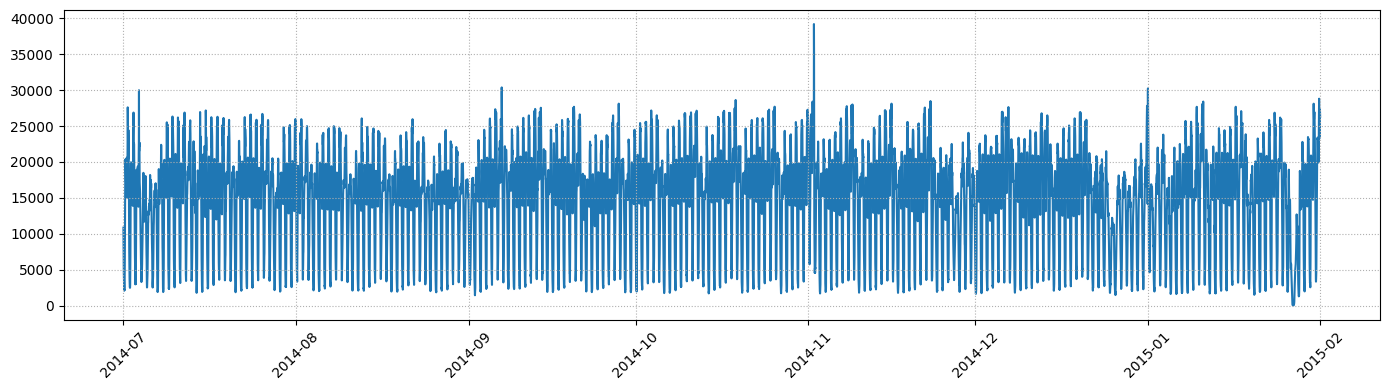

In [45]:
util.plot_series(data, figsize=figsize)

* Some outliers are visible, but there might be more anomalies

## A Look at the Data

**Anomalies for this time series are labeled**

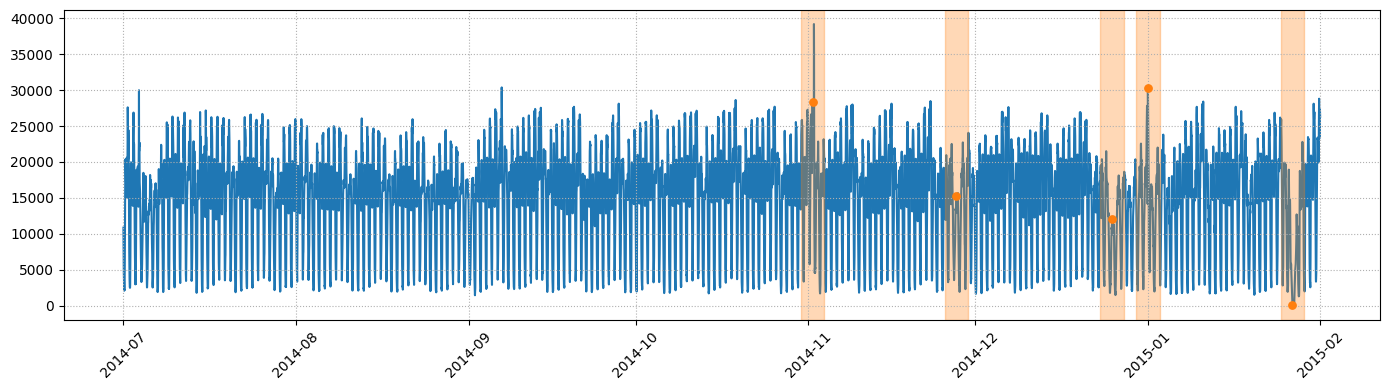

In [46]:
util.plot_series(data, labels, windows, figsize=figsize)

* We also have access to windows the define where a detection is meaningful
* Detections outside the windows count as a miss

## Problem Formalization

**A possible approach: we know that anomalies are (often) unlikely**

* If we can estimate the probability of every occurring observation $x$
* ...Then we can spot anomalies based on their _low probability_

> **We turn a liability into a strenght!**

**Formally, our detection condition can be stated as:**

$$
f(x) \leq \theta
$$

* Where $f(x)$ is a _Probability Density Function (PDF)_
* ...And $\theta$ is a (scalar) threshold

**However, we lack ground truth information for the probabilities!**

## Density Estimation

**Luckily, we can still obain an estimator**

Say we have a parameterized approximator $\tilde{f}(x, \omega)$ for the true density $f(x)$

* We can try to choose the parameters $\omega$
* ...So as to maximize the estimate probability of the training sample:

$$
\text{argmax}_\theta \prod_{i=1}^m \tilde{f}(x_i, \omega)
$$

**This is an example of an _unsupervised learning problem_**

* Even if we lack supervision (we know nothing about the anomalies)
* ...We can still make some use of our data

## Training and Testing

**We will split our data in two segments**

A _training set_:

* This will include only data about the _normal_ behavior
* Ideally, there should be no anomalies here (we do not want to learn them!)
* We will use it to fit a KDE model

A _test set_:

* To assess how well the approach can generalize

**If the training set contains some anomalies**

* Things may still be fine, as long as they are very _infrequent_
* ...Since we will still learn that they have low probability


## Training and Testing

**In time series data sets are often split chronologically:**

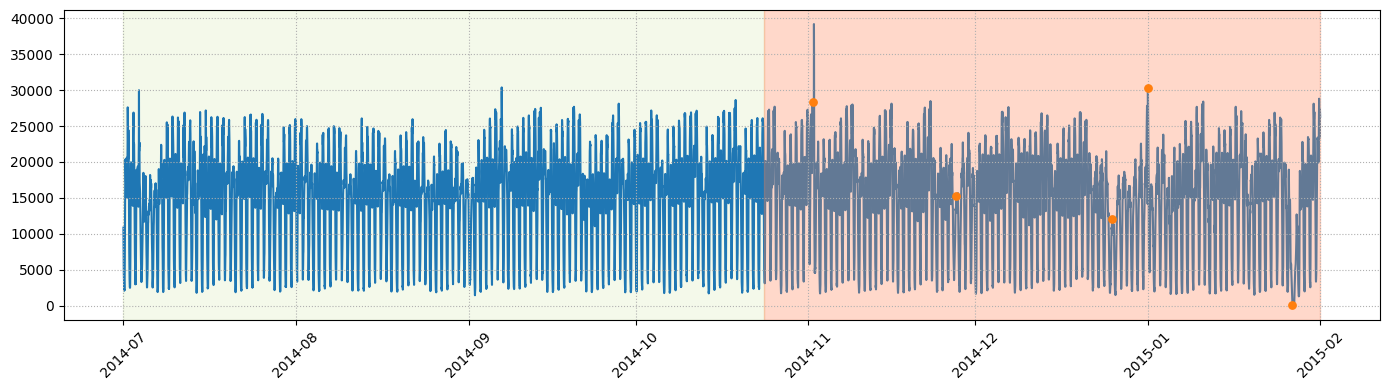

In [47]:
train_end = pd.to_datetime('2014-10-24 00:00:00')
util.plot_series(data, labels, test_start=train_end, figsize=figsize)

* Green: training set, orange: test set

## Input Choice

**We have some flexibility in choosing our input**

We know that we are going to train an estimator:

$$
\tilde{f}(x, \omega)
$$

...But what does $x$ represent?

* For sure, the number of taxi calls
* ...But we can add more pieces of information if that is useful

**With times series a useful piece of information is given by _time_**

* We have it "for free" (this is a time series, after all)
* ...And it naturally plays a role in many phenomena

## Time and Taxi Calls

**Let's zoom a bit on our series**

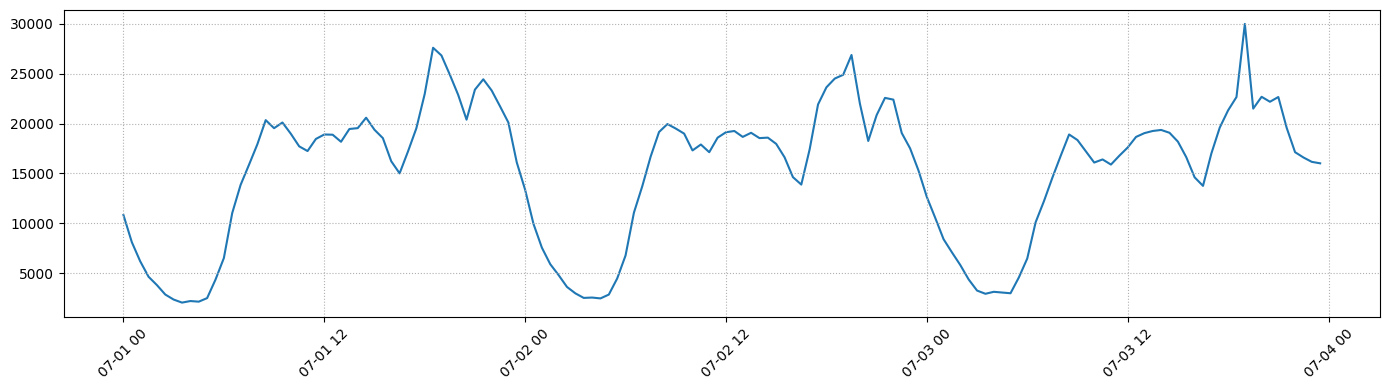

In [48]:
util.plot_series(data.iloc[:3*48], figsize=figsize)

* There is recurring pattern! This is natural for many human activities
* In other words: at least _some aspects of time_ have a strong impact

## Time as an Additional Input

**One way to look at that:**

* The distribution depends on the time of the day
* Equivalently: our observed variable has _two components_, i.e. $y = (t, x)$
  - The first component $t$ is the _time of the day_
  - The second component $x$ is the number of called taxis
 
**Let us extract (from the index) this new information:**

In [49]:
dayhour = (data.index.hour + data.index.minute / 60)

We can then add it as a separate column to the data:

In [50]:
data2 = data.copy()
data2['dayhour'] = dayhour

## Multivariate Distribution

**Let us examine the resulting multivariate distribution**

We can use a 2D histogram:

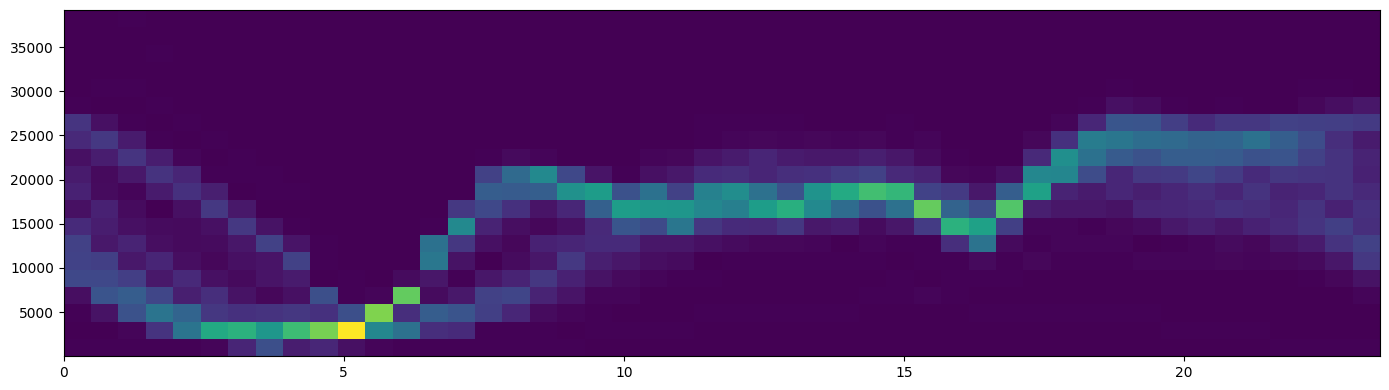

In [51]:
util.plot_histogram2d(data2['dayhour'], data2['value'], bins=(48, 20), figsize=figsize)

* x = time, y = value, color = frequency of occurrence

## Anomaly Detection with Controlled Variables

**We need ot be a bit careful with our new estimator**

If we just check this condition:

$$
\tilde{f}((t, x), \omega) \leq \theta
$$

...We might get some strange results:

* If a value of time is under-represented in our data
* ...The model will think it is unlikely


**Once we are aware of the issue, it can be solved by tweaking the formula**

$$
\frac{\tilde{f}((t, x), \omega)}{\tilde{f}^"(t, \omega^")} \leq \theta
$$

Basically, we use a conditional probability rather than a joint probability

## Data Preparation and Training

**We start by separating the training set and applying normalization**

In [52]:
scaler = MinMaxScaler()
data2_n_tr = data2[data2.index < train_end].copy()
data2_n_tr[:] = scaler.fit_transform(data2_n_tr)
data2_n = data2.copy()
data2_n[:] = scaler.transform(data2)

**Then we can then train a density estimator**

In [54]:
from sklearn.model_selection import GridSearchCV
params = {'bandwidth': np.linspace(0.001, 0.01, 10)}
opt = GridSearchCV(KernelDensity(kernel='gaussian'), params, cv=5)
opt.fit(data2_n_tr);

* We are using Kernel Density Estimation to obtain $\tilde{f}$
* ...Which is a relatively simple technique

## Alarm Signal

**It is customary to show alarm signals rather than probabilities**

We can obtain one by computing $-\log \tilde{f}(x, \omega)$

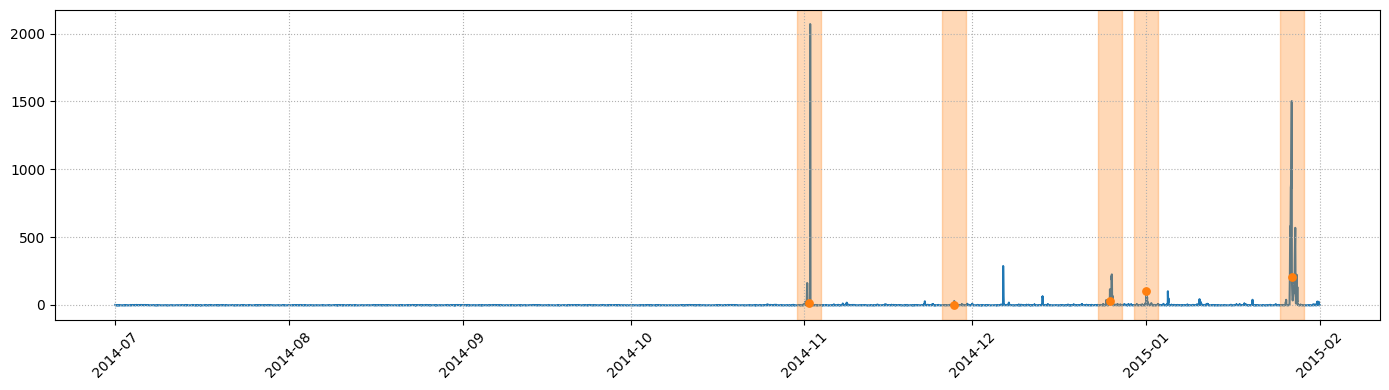

In [59]:
ldens = opt.score_samples(data2_n)
signal = pd.Series(index=data2.index, data=-ldens2)
util.plot_series(signal2, labels=labels, windows=windows, figsize=figsize)

Even at a glance, we are doing a decent job

## Detecting Anomalies

**Let's see what happens when we fix a threshold**

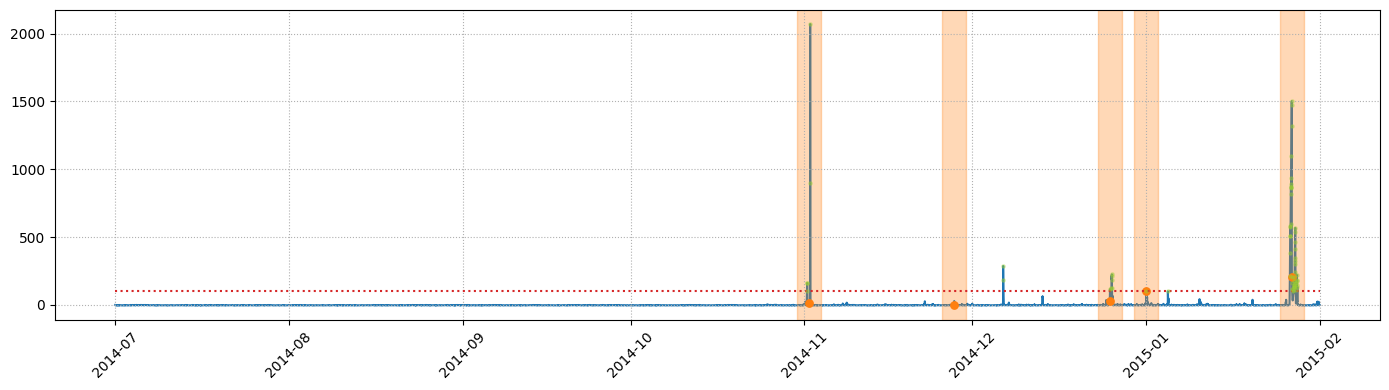

In [63]:
thr = 100
util.plot_series(signal, labels=labels, windows=windows, predictions=pd.Series(signal.index[signal >= thr]), threshold=thr, figsize=figsize)

* Points _above_ the threshold will be detected as anomalies

## Choosing a Threshold

**For choosing a threshold, we need _two ingredients_**

The first is a _validation set_, containing some anomalies

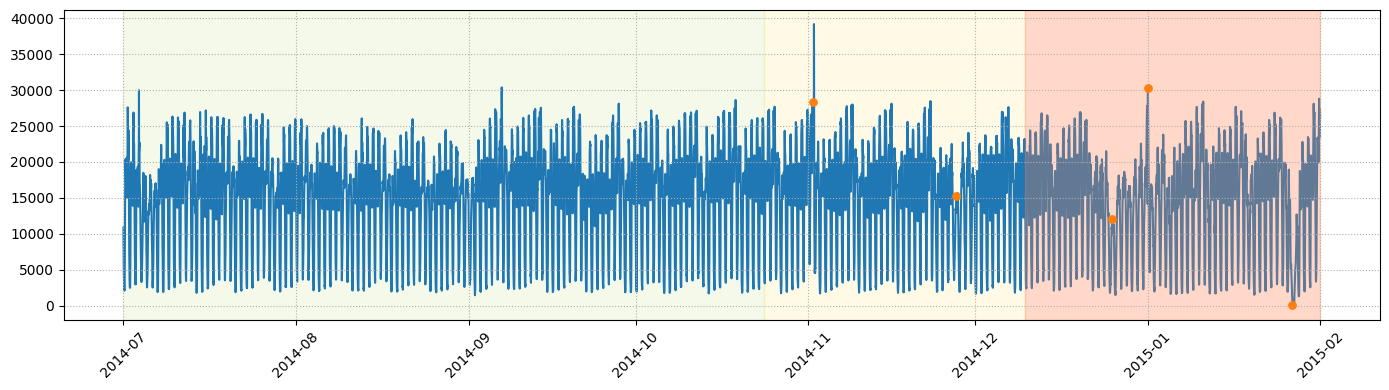

In [65]:
val_end = pd.to_datetime('2014-12-10 00:00:00')
util.plot_series(data, labels, val_start=train_end, test_start=val_end, figsize=figsize)

* Some data still needs to be left out for the final evaluation

## Choosing a Threshold

**The second is a _cost model_**

In other words, we need to asses how using the system costs to us

* In an industrial setting, we care about the _value_ generated by a system
* Standard accuracy metrics fail to capture this

**We will use a very simple cost model:**

$$
c_{alarm} \times \text{#false_alarms} + c_{missed} \times  \text{#missed_anomalies} + c_{late} \times  \text{#late_detections}
$$

* A cost $c_{alarm}$ for loosing time in analyzing false positives
* A cost $c_{missed}$ for missing an anomaly
* A cost $c_{late}$ for a late detection (partial loss of value)

In [76]:
c_alrm, c_missed, c_late = 1, 10, 5

## Threshold Optimization

**Now, let us optimize our threshold:**

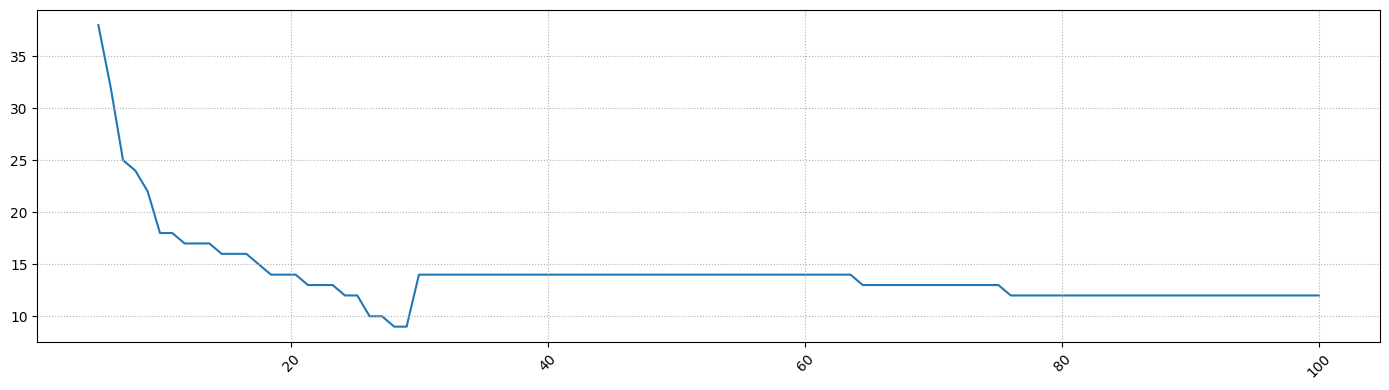

In [86]:
cmodel = util.ADSimpleCostModel(c_alrm, c_missed, c_late)
thr_range = np.linspace(5, 100, 100)
cost_range = pd.Series(index=thr_range, data=[cmodel.cost(signal[signal.index <= val_end], labels[labels <= val_end], windows[windows.end <= val_end], thr) for thr in thr_range])
util.plot_series(cost_range, figsize=figsize)

* On the $x$-axis we have $\theta$, on the $y$-axis the cost

## Threshold Optimization

**Now, let us optimize our threshold:**

In [91]:
signal_opt = signal[signal.index < val_end]
labels_opt = labels[labels < val_end]
windows_opt = windows[windows['end'] < val_end]
thr_range = np.linspace(5, 100, 100)
best_thr, best_cost = util.opt_thr(signal_opt, labels_opt, windows_opt, cmodel, thr_range)
print(f'Best threshold: {best_thr}, corresponding cost: {best_cost}')

Best threshold: 28.03030303030303, corresponding cost: 9


And finally we can check the performance on the whole dataset:

In [90]:
ctst = cmodel.cost(signal2, labels, windows, best_thr)
print(f'Cost on the whole dataset {ctst}')

Cost on the whole dataset 18
